# Simple inversion demonstration


#### In this notebook we will demonstrate the process of inverting a single polarized spectrum with the goal of obtaining the parameters of the slab: magnetic field vector (Bx, By, Bz), optical depth, los and thermal velocity, and damping. We also have an option of fitting the ad-hoc beta parameter, that we will not use. We will also always assume filling factor is 1, i.e. we are not mixing multiple models for a single spectrum. 

#### Let's start by generating an example spectrum, and adding some noise to it.

In [13]:
import numpy as np 
import matplotlib.pyplot as plt 
import hazel
import h5py

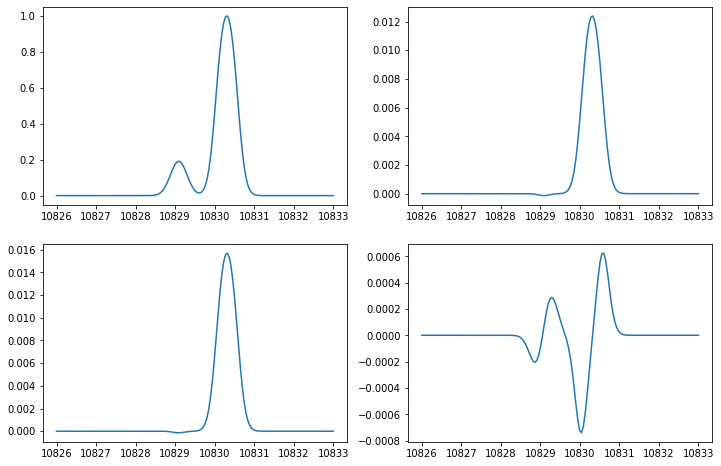

In [45]:
mod = hazel.Model(working_mode='synthesis')
mod.add_spectral({'Name': 'spec1', 'Wavelength': [10826, 10833, 150], 'topology': 'ch1',
    'LOS': [90.0,0.0,90.0], 'Boundary condition': [0.0,0.0,0.0,0.0]})
mod.add_chromosphere({'Name': 'ch1', 'Spectral region': 'spec1', 'Height': 15.0, 'Line': '10830', 'Wavelength': [10826, 10833]})
mod.setup()
# Vector of parameters are (Bx,By,Bztau,v,deltav,beta,a) and then the ff
mod.atmospheres['ch1'].set_parameters([4.0,-3.0,7.0,1.0,0.0,8.0,1.0,0.0],1.0)
mod.synthesize()

# This is where the wavelength hides
ll = mod.spectrum['spec1'].wavelength_axis
n_wvl = len(ll)

plt.figure(figsize=[12,8])
plt.subplot(221)
plt.plot(ll,mod.spectrum['spec1'].stokes[0,:])
plt.subplot(222)
plt.plot(ll,mod.spectrum['spec1'].stokes[1,:])
plt.subplot(223)
plt.plot(ll,mod.spectrum['spec1'].stokes[2,:])
plt.subplot(224)
plt.plot(ll,mod.spectrum['spec1'].stokes[3,:])



#### Note that in this case, Stokes V is very weak. We will set a very low noise as well, to be able to fit it, but generally expec noisy spectra in this case! 

In [46]:
# Generate random noise of a given amplitude.
noise_lvl = 2E-6

random_noise = np.random.normal(0,noise_lvl,4*150)
random_noise = random_noise.reshape(4,150)
random_noise.shape

(4, 150)

In [47]:
mod.spectrum['spec1'].stokes += random_noise

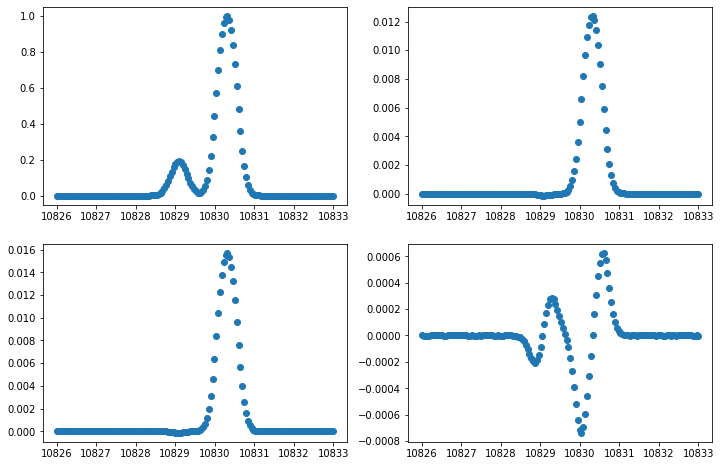

In [48]:
plt.figure(figsize=[12,8])
plt.subplot(221)
plt.plot(ll,mod.spectrum['spec1'].stokes[0,:],'o')
plt.subplot(222)
plt.plot(ll,mod.spectrum['spec1'].stokes[1,:],'o')
plt.subplot(223)
plt.plot(ll,mod.spectrum['spec1'].stokes[2,:],'o')
plt.subplot(224)
plt.plot(ll,mod.spectrum['spec1'].stokes[3,:],'o')

#### Now our next step is to store this data (spectra, noise, weigths, line-of-sight) in a way where a new hazel model, intended for inversion can read it, and hopefully give us some meaningful results. Best would be if we got back our original magnetic field that we put in! 

In [49]:
# First the wavelength axis
np.savetxt('10830_test.wavelength', ll, header='lambda')

# Then we will save something called, 'weigths', this will allow us to fine-tune the inversion if needed.
f = open('10830_test.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_wvl):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()

# And finally, the 'observed' Stokes parameters:

stokes = np.copy(mod.spectrum['spec1'].stokes)

f = open('10830_test_stokes.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'90.0 0.0 90.0\n') # This should be identical to the above otherwise we will get inconsistent results. 
                            # this is something you should know from the observations
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'0.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes, noise_lvl*np.ones((4,n_wvl))]) # the second one only adds appropriate noise next to each Stokes
                                                        # measurement
np.savetxt(f, tmp.T)
f.close()

### Take a look at the files you just made! 

. 

.

.

.

.

### Ok, the next step is to set-up an inversion. 

### To do that, you want to play with conf_test.ini file. Let's do that in a separate editor.

.

.

.

.

.

### And after that you are ready for an inversion! 

In [50]:
# We will do it as similarly to the parallel version as possible, so that later we got to change minimal amount of things.
iterator = hazel.Iterator(use_mpi=False)
mod = hazel.Model('conf_test.ini', working_mode='inversion', verbose=3, rank=iterator.get_rank(), randomization=1)
iterator.use_model(model=mod)
iterator.run_all_pixels()

2022-01-24 17:16:25,373 - Hazel2 v1.0
2022-01-24 17:16:25,374 - Using configuration from file : conf_test.ini
2022-01-24 17:16:25,375 - Backtracking mode : brent
2022-01-24 17:16:25,376 - Adding spectral region spec1
2022-01-24 17:16:25,376 -   - Reading wavelength axis from 10830_test.wavelength
2022-01-24 17:16:25,377 -   - Reading wavelength weights from 10830_test.weights
2022-01-24 17:16:25,378 -   - Using observations from 10830_test_stokes.1d
2022-01-24 17:16:25,379 -   - No mask for pixels
2022-01-24 17:16:25,379 -   - No instrumental profile
2022-01-24 17:16:25,379 -   - Using LOS ['90.00', '0.0', '90.0']
2022-01-24 17:16:25,379 -   - Using off-limb normalization (peak intensity)
2022-01-24 17:16:25,380 -   - Using boundary condition ['0.0', '0.0', '0.0', '0.0']
2022-01-24 17:16:25,380 - Using 2 cycles
2022-01-24 17:16:25,380 - Using analytical RFs if possible : False
2022-01-24 17:16:25,380 - Using 10 max. iterations
2022-01-24 17:16:25,381 - Not using randomizations
2022-01-

2022-01-24 17:16:32,144 - ch1
2022-01-24 17:16:32,144 - -----------
2022-01-24 17:16:32,144 -      Bx        By        Bz        tau       v       deltav      beta      a
2022-01-24 17:16:32,144 -    0.000     0.000     0.000     0.971     0.001     8.030     1.000     0.000
2022-01-24 17:16:32,145 - ==============================================================================
2022-01-24 17:16:32,145 - It: 9 - chi2: 12504.078227 - lambda_opt:   3.844321 - rel:   0.001164
2022-01-24 17:16:32,145 - ==============================================================================
2022-01-24 17:16:32,853 - 
2022-01-24 17:16:32,853 - -----------
2022-01-24 17:16:32,854 - ch1
2022-01-24 17:16:32,854 - -----------
2022-01-24 17:16:32,854 -      Bx        By        Bz        tau       v       deltav      beta      a
2022-01-24 17:16:32,854 -    0.000     0.000     0.000     0.971     0.001     8.030     1.000     0.000
2022-01-24 17:16:32,855 - ===================================================

2022-01-24 17:16:40,579 - ch1
2022-01-24 17:16:40,580 - -----------
2022-01-24 17:16:40,580 -      Bx        By        Bz        tau       v       deltav      beta      a
2022-01-24 17:16:40,580 -    4.059    -3.059     7.194     0.970     0.001     8.030     1.000     0.000
2022-01-24 17:16:40,580 - ==============================================================================
2022-01-24 17:16:40,581 - It: 9 - chi2:   3.340158 - lambda_opt:   0.000110 - rel:   1.374808
2022-01-24 17:16:40,581 - ==============================================================================
2022-01-24 17:16:41,235 - 
2022-01-24 17:16:41,235 - -----------
2022-01-24 17:16:41,236 - ch1
2022-01-24 17:16:41,236 - -----------
2022-01-24 17:16:41,236 -      Bx        By        Bz        tau       v       deltav      beta      a
2022-01-24 17:16:41,236 -    4.020    -3.025     7.121     0.970     0.001     8.030     1.000     0.000
2022-01-24 17:16:41,237 - =====================================================

In [51]:
%cp output_onepixel.h5 output_for_reading.h5

In [52]:
# If you were curious you might have noticed that some of the parameters are very poorly reproduced.
# Let's see if the spectrum fits at all! 


result = h5py.File('output_for_reading.h5','r')
result.keys()



<KeysViewHDF5 ['ch1', 'spec1']>

In [53]:
fit = np.copy(result['spec1']['stokes'])

In [54]:
fit.shape

(1, 1, 4, 150)

In [55]:
fit = fit[0,0]

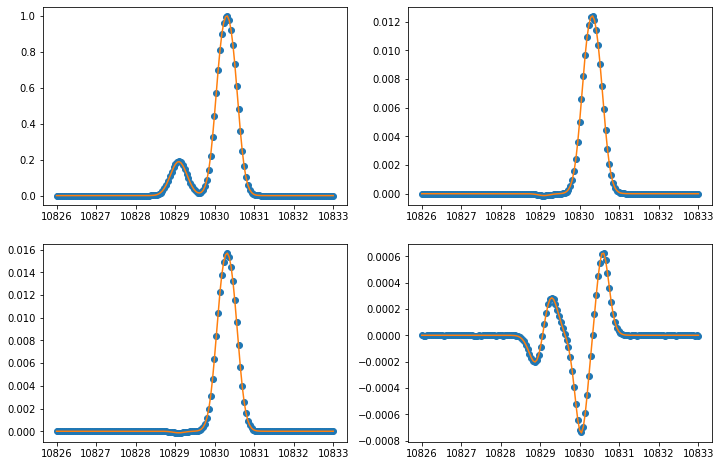

In [56]:
plt.figure(figsize=[12,8])
plt.subplot(221)
plt.plot(ll,stokes[0,:],'o')
plt.plot(ll,fit[0,:])
plt.subplot(222)
plt.plot(ll,stokes[1,:],'o')
plt.plot(ll,fit[1,:])
plt.subplot(223)
plt.plot(ll,stokes[2,:],'o')
plt.plot(ll,fit[2,:])
plt.subplot(224)
plt.plot(ll,stokes[3,:],'o')
plt.plot(ll,fit[3,:])

In [57]:
# Now let's look whether we recovered original parameters:

result['ch1'].keys()

<KeysViewHDF5 ['B', 'B_err', 'B_nodes', 'Bx', 'Bx_err', 'Bx_nodes', 'By', 'By_err', 'By_nodes', 'Bz', 'Bz_err', 'Bz_nodes', 'a', 'a_err', 'a_nodes', 'beta', 'beta_err', 'beta_nodes', 'deltav', 'deltav_err', 'deltav_nodes', 'ff', 'ff_err', 'ff_nodes', 'phiB', 'phiB_err', 'phiB_nodes', 'tau', 'tau_err', 'tau_nodes', 'thB', 'thB_err', 'thB_nodes', 'v', 'v_err', 'v_nodes']>

In [58]:
# Print them neatly:
print ("Bx= ",result['ch1']['Bx'][0,0,0])
print ("By= ",result['ch1']['By'][0,0,0])
print ("Bz= ",result['ch1']['Bz'][0,0,0])
print ("tau= ",result['ch1']['tau'][0,0,0])
print ("vlos ",result['ch1']['v'][0,0,0])
print ("vtherm= ",result['ch1']['deltav'][0,0,0])
print ("a= ",result['ch1']['a'][0,0,0])

Bx=  4.009449707131132
By=  -3.015278017928594
Bz=  7.030496227277119
tau=  0.9704854935046927
vlos  0.0006409253168726536
vtherm=  8.03011330707704
a=  1.0814710799760049e-07


### Repeat the exercise with a much smaller amount of noise and see if it helps!